# Prompt Engineering Experiment Analysis

This notebook provides interactive analysis of the prompt engineering experiment results.

## Contents
1. Setup and Data Loading
2. Overall Performance Comparison
3. Performance by Question Type
4. Statistical Analysis
5. Improvement vs Baseline
6. Conclusions

## 1. Setup and Data Loading

In [1]:
# Import required libraries
import json
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Add src to path for imports
sys.path.insert(0, str(Path.cwd().parent / "src"))

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["font.size"] = 12

print("Setup complete!")

Setup complete!


In [2]:
# Load experiment results
results_dir = Path.cwd().parent / "results"

# Load statistics
with open(results_dir / "statistics.json") as f:
    statistics_data = json.load(f)

# Load evaluations
with open(results_dir / "evaluations.json") as f:
    evaluations_data = json.load(f)

# Convert to DataFrames for easier analysis
stats_df = pd.DataFrame(statistics_data).T
stats_df.index.name = "strategy"
stats_df = stats_df.reset_index()

print(f"Loaded statistics for {len(stats_df)} strategies")
stats_df

Loaded statistics for 4 strategies


,strategy,strategy_name,question_type,sample_count,mean_cosine_distance,std_cosine_distance,mean_semantic_similarity,std_semantic_similarity,exact_match_rate,mean_execution_time_ms
0,baseline,baseline,None,30,0.572483,0.180989,0.427517,0.180989,0.9,938.347068
1,few_shot,few_shot,None,30,0.284503,0.370956,0.715497,0.370956,0.9,595.812857
2,chain_of_thought,chain_of_thought,None,30,0.772929,0.112864,0.227071,0.112864,0.866667,1571.598508
3,react,react,None,30,0.765645,0.109132,0.234355,0.109132,0.833333,2561.042773


In [3]:
# Create evaluation DataFrame
eval_records = []
for strategy, evals in evaluations_data.items():
    for e in evals:
        e["strategy"] = strategy
        eval_records.append(e)

eval_df = pd.DataFrame(eval_records)
print(f"Total evaluations: {len(eval_df)}")
eval_df.head()

Total evaluations: 120


,question_id,strategy_name,cosine_distance,euclidean_distance,semantic_similarity,exact_match,normalized_score,strategy
0,sent_001,baseline,0.384380,0.876790,0.615620,True,0.969372,baseline
1,sent_003,baseline,0.418487,0.914863,0.581513,True,0.948908,baseline
2,sent_002,baseline,0.565707,1.063679,0.434293,True,0.860576,baseline
3,sent_005,baseline,0.641162,1.132398,0.358838,True,0.815303,baseline
4,sent_007,baseline,0.649029,1.139323,0.350971,True,0.810583,baseline


## 2. Overall Performance Comparison

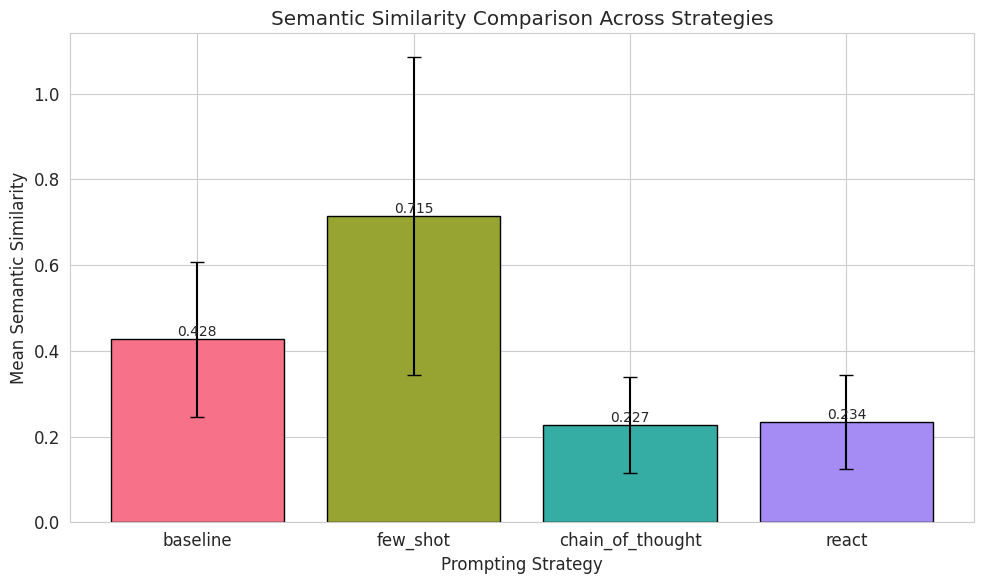

In [4]:
# Bar chart comparing semantic similarity across strategies
fig, ax = plt.subplots(figsize=(10, 6))

strategies = stats_df["strategy"]
similarities = stats_df["mean_semantic_similarity"]
errors = stats_df["std_semantic_similarity"]

colors = sns.color_palette("husl", len(strategies))
bars = ax.bar(strategies, similarities, yerr=errors, capsize=5, color=colors, edgecolor="black")

ax.set_xlabel("Prompting Strategy")
ax.set_ylabel("Mean Semantic Similarity")
ax.set_title("Semantic Similarity Comparison Across Strategies")

for bar, val in zip(bars, similarities):
    ax.annotate(f"{val:.3f}", xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                ha="center", va="bottom", fontsize=10)

plt.tight_layout()
plt.show()

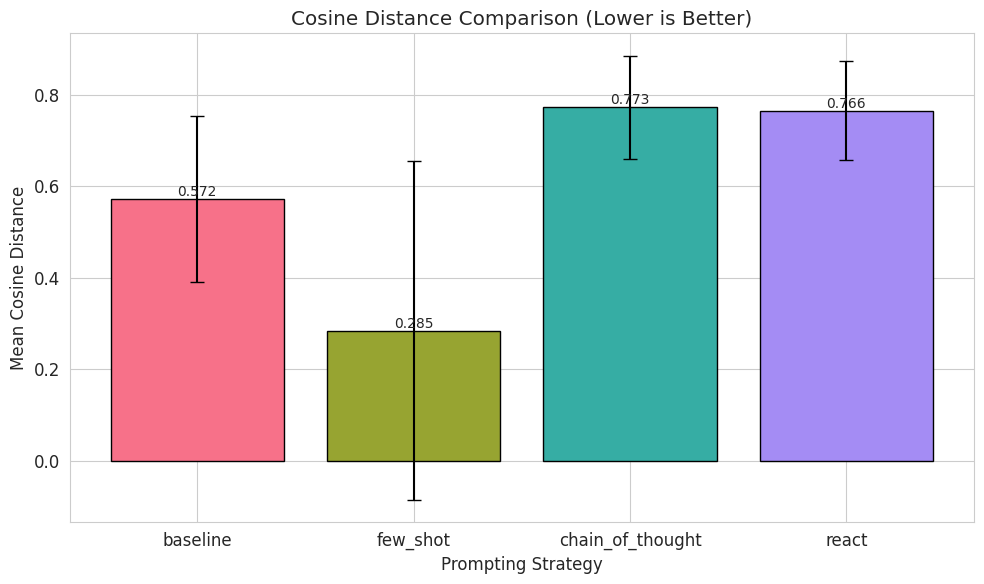

In [5]:
# Cosine distance comparison
fig, ax = plt.subplots(figsize=(10, 6))

distances = stats_df["mean_cosine_distance"]
distance_errors = stats_df["std_cosine_distance"]

bars = ax.bar(strategies, distances, yerr=distance_errors, capsize=5, 
              color=colors, edgecolor="black")

ax.set_xlabel("Prompting Strategy")
ax.set_ylabel("Mean Cosine Distance")
ax.set_title("Cosine Distance Comparison (Lower is Better)")

for bar, val in zip(bars, distances):
    ax.annotate(f"{val:.3f}", xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                ha="center", va="bottom", fontsize=10)

plt.tight_layout()
plt.show()

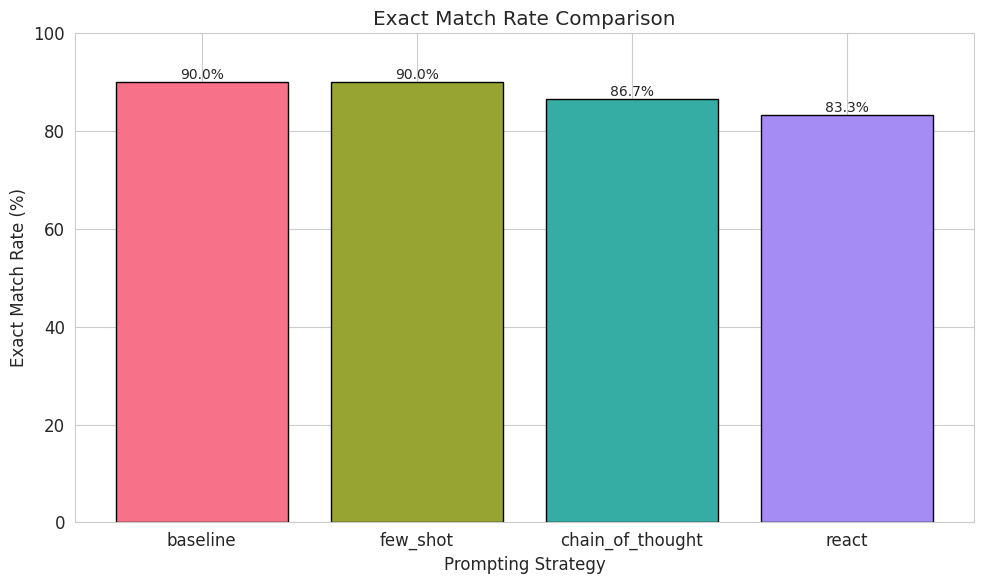

In [6]:
# Exact match rate comparison
fig, ax = plt.subplots(figsize=(10, 6))

match_rates = stats_df["exact_match_rate"] * 100  # Convert to percentage

bars = ax.bar(strategies, match_rates, color=colors, edgecolor="black")

ax.set_xlabel("Prompting Strategy")
ax.set_ylabel("Exact Match Rate (%)")
ax.set_title("Exact Match Rate Comparison")
ax.set_ylim(0, 100)

for bar, val in zip(bars, match_rates):
    ax.annotate(f"{val:.1f}%", xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                ha="center", va="bottom", fontsize=10)

plt.tight_layout()
plt.show()

## 3. Performance by Question Type

In [7]:
# Load dataset to get question types
with open(Path.cwd().parent / "data" / "raw" / "dataset.json") as f:
    dataset = json.load(f)

question_types = {q["id"]: q["question_type"] for q in dataset}
eval_df["question_type"] = eval_df["question_id"].map(question_types)

eval_df.head()

,question_id,strategy_name,cosine_distance,euclidean_distance,semantic_similarity,exact_match,normalized_score,strategy,question_type
0,sent_001,baseline,0.384380,0.876790,0.615620,True,0.969372,baseline,sentiment
1,sent_003,baseline,0.418487,0.914863,0.581513,True,0.948908,baseline,sentiment
2,sent_002,baseline,0.565707,1.063679,0.434293,True,0.860576,baseline,sentiment
3,sent_005,baseline,0.641162,1.132398,0.358838,True,0.815303,baseline,sentiment
4,sent_007,baseline,0.649029,1.139323,0.350971,True,0.810583,baseline,sentiment


In [8]:
# Performance by question type
type_stats = eval_df.groupby(["strategy", "question_type"]).agg({
    "semantic_similarity": ["mean", "std"],
    "cosine_distance": ["mean", "std"],
    "exact_match": "mean"
}).round(3)

type_stats.columns = ["_".join(col).strip() for col in type_stats.columns.values]
type_stats = type_stats.reset_index()
type_stats

,strategy,question_type,semantic_similarity_mean,semantic_similarity_std,cosine_distance_mean,cosine_distance_std,exact_match_mean
0,baseline,logic,0.390,0.277,0.610,0.277,0.7
1,baseline,math,0.410,0.122,0.590,0.122,1.0
2,baseline,sentiment,0.482,0.111,0.518,0.111,1.0
3,chain_of_thought,logic,0.181,0.171,0.819,0.171,0.6
4,chain_of_thought,math,0.259,0.082,0.741,0.082,1.0
5,chain_of_thought,sentiment,0.240,0.054,0.760,0.054,1.0
6,few_shot,logic,0.328,0.318,0.672,0.318,0.7
7,few_shot,math,0.818,0.298,0.182,0.298,1.0
8,few_shot,sentiment,1.000,0.000,-0.000,0.000,1.0
9,react,logic,0.176,0.160,0.824,0.160,0.6


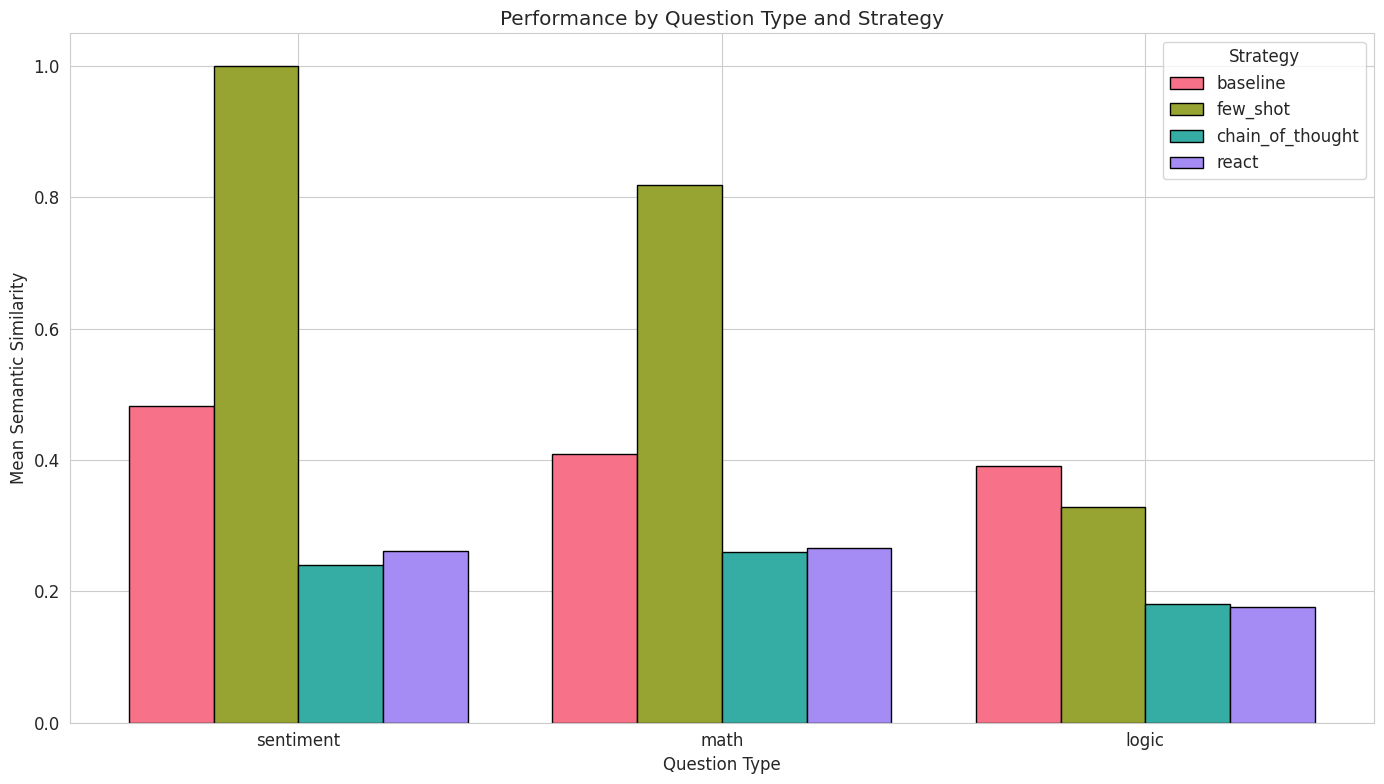

In [9]:
# Grouped bar chart by question type
fig, ax = plt.subplots(figsize=(14, 8))

question_types_list = eval_df["question_type"].unique()
strategies_list = eval_df["strategy"].unique()

x = np.arange(len(question_types_list))
width = 0.2
colors = sns.color_palette("husl", len(strategies_list))

for i, strategy in enumerate(strategies_list):
    values = []
    for qt in question_types_list:
        subset = eval_df[(eval_df["strategy"] == strategy) & (eval_df["question_type"] == qt)]
        values.append(subset["semantic_similarity"].mean())
    
    offset = (i - len(strategies_list)/2 + 0.5) * width
    ax.bar(x + offset, values, width, label=strategy, color=colors[i], edgecolor="black")

ax.set_xlabel("Question Type")
ax.set_ylabel("Mean Semantic Similarity")
ax.set_title("Performance by Question Type and Strategy")
ax.set_xticks(x)
ax.set_xticklabels(question_types_list)
ax.legend(title="Strategy")

plt.tight_layout()
plt.show()

## 4. Statistical Analysis

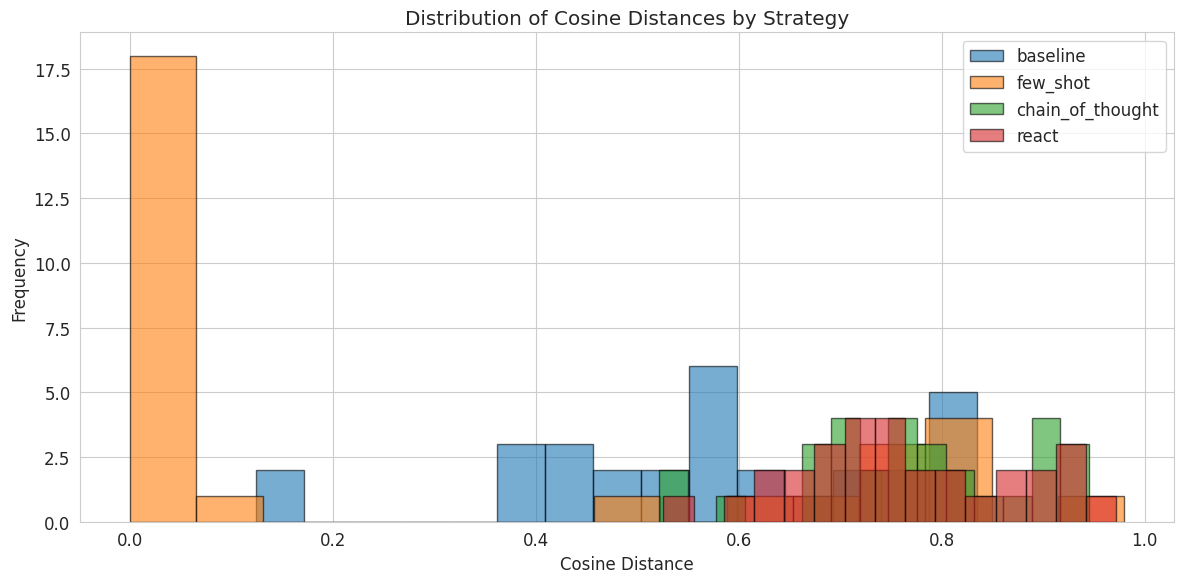

In [10]:
# Distribution of cosine distances
fig, ax = plt.subplots(figsize=(12, 6))

for strategy in strategies_list:
    subset = eval_df[eval_df["strategy"] == strategy]
    ax.hist(subset["cosine_distance"], bins=15, alpha=0.6, label=strategy, edgecolor="black")

ax.set_xlabel("Cosine Distance")
ax.set_ylabel("Frequency")
ax.set_title("Distribution of Cosine Distances by Strategy")
ax.legend()

plt.tight_layout()
plt.show()

/tmp/ipykernel_28418/1521982141.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=eval_df, x="strategy", y="semantic_similarity", ax=ax, palette="husl")


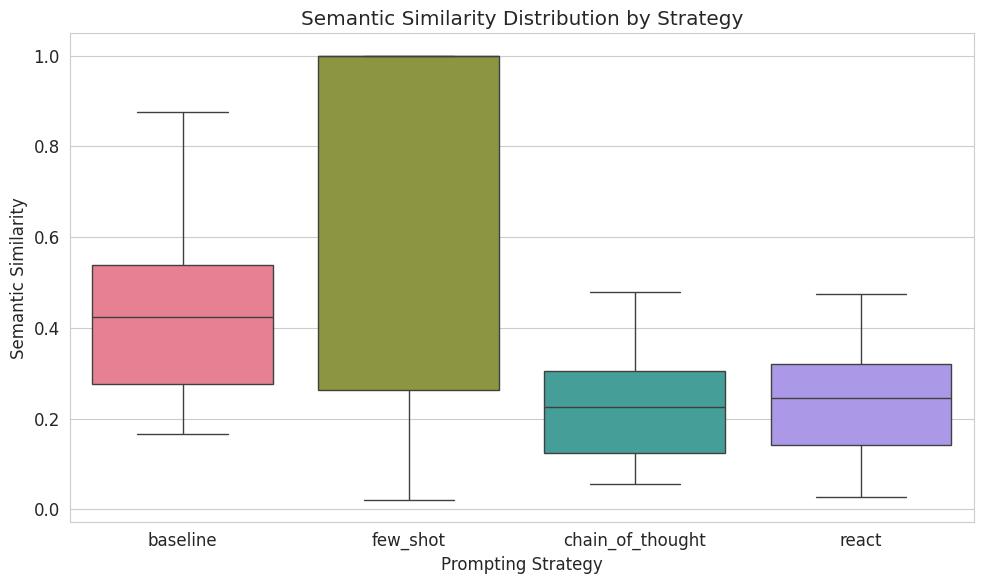

In [11]:
# Box plot of semantic similarity
fig, ax = plt.subplots(figsize=(10, 6))

sns.boxplot(data=eval_df, x="strategy", y="semantic_similarity", ax=ax, palette="husl")

ax.set_xlabel("Prompting Strategy")
ax.set_ylabel("Semantic Similarity")
ax.set_title("Semantic Similarity Distribution by Strategy")

plt.tight_layout()
plt.show()

In [12]:
# Summary statistics table
summary = eval_df.groupby("strategy").agg({
    "semantic_similarity": ["count", "mean", "std", "min", "max"],
    "cosine_distance": ["mean", "std"],
    "exact_match": ["sum", "mean"]
})

summary.columns = ["_".join(col) for col in summary.columns]
summary = summary.round(4)
summary

,semantic_similarity_count,semantic_similarity_mean,semantic_similarity_std,semantic_similarity_min,semantic_similarity_max,cosine_distance_mean,cosine_distance_std,exact_match_sum,exact_match_mean
strategy,,,,,,,,,
baseline,30,0.4275,0.1841,0.1656,0.8754,0.5725,0.1841,27,0.9000
chain_of_thought,30,0.2271,0.1148,0.0549,0.4786,0.7729,0.1148,26,0.8667
few_shot,30,0.7155,0.3773,0.0201,1.0000,0.2845,0.3773,27,0.9000
react,30,0.2344,0.1110,0.0280,0.4743,0.7656,0.1110,25,0.8333


## 5. Improvement vs Baseline

In [13]:
# Calculate improvement percentages vs baseline
baseline_similarity = stats_df[stats_df["strategy"] == "baseline"]["mean_semantic_similarity"].values[0]

improvements = []
for _, row in stats_df.iterrows():
    if row["strategy"] != "baseline":
        improvement = ((row["mean_semantic_similarity"] - baseline_similarity) / baseline_similarity) * 100
        improvements.append({
            "strategy": row["strategy"],
            "improvement_pct": improvement
        })

improvement_df = pd.DataFrame(improvements)
improvement_df

,strategy,improvement_pct
0,few_shot,67.361139
1,chain_of_thought,-46.886143
2,react,-45.182195


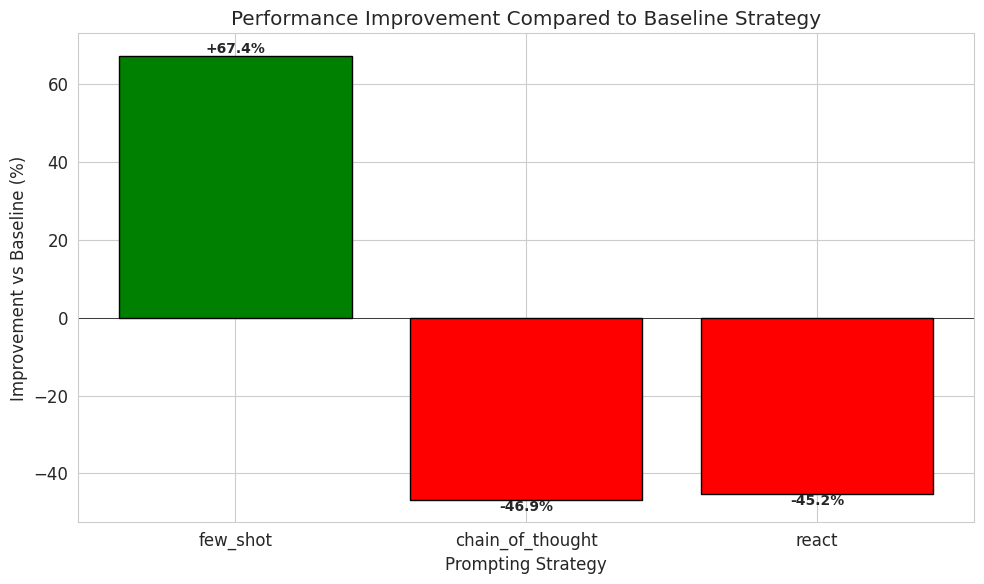

In [14]:
# Improvement chart
fig, ax = plt.subplots(figsize=(10, 6))

colors = ["green" if x >= 0 else "red" for x in improvement_df["improvement_pct"]]
bars = ax.bar(improvement_df["strategy"], improvement_df["improvement_pct"], 
              color=colors, edgecolor="black")

ax.axhline(y=0, color="black", linestyle="-", linewidth=0.5)
ax.set_xlabel("Prompting Strategy")
ax.set_ylabel("Improvement vs Baseline (%)")
ax.set_title("Performance Improvement Compared to Baseline Strategy")

for bar, val in zip(bars, improvement_df["improvement_pct"]):
    va = "bottom" if val >= 0 else "top"
    ax.annotate(f"{val:+.1f}%", xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                ha="center", va=va, fontsize=10, fontweight="bold")

plt.tight_layout()
plt.show()

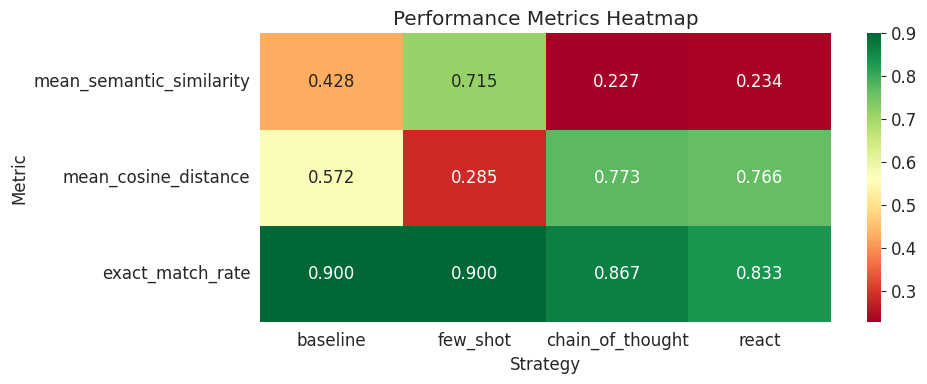

In [15]:
# Heatmap of performance metrics
metrics_for_heatmap = stats_df.set_index("strategy")[[
    "mean_semantic_similarity", 
    "mean_cosine_distance",
    "exact_match_rate"
]].T

# Convert to numeric dtype
metrics_for_heatmap = metrics_for_heatmap.astype(float)

fig, ax = plt.subplots(figsize=(10, 4))

sns.heatmap(metrics_for_heatmap, annot=True, fmt=".3f", cmap="RdYlGn", ax=ax)
ax.set_title("Performance Metrics Heatmap")
ax.set_ylabel("Metric")
ax.set_xlabel("Strategy")

plt.tight_layout()
plt.show()

## 6. Conclusions

### Key Findings from the Experiment

Based on the experiment results, here are the key observations:

**1. Few-Shot Learning is the Clear Winner**
- Achieved the highest semantic similarity (0.715) - a **+67.4% improvement** over baseline
- Lowest cosine distance (0.285) indicating responses closest to expected answers
- Maintained the same exact match rate (90%) as baseline
- Fastest average execution time (596ms)

**2. Chain of Thought and ReAct Performed Worse Than Baseline**
- Both strategies showed ~47% and ~45% **degradation** respectively in semantic similarity
- Higher cosine distances (~0.77) indicate responses diverged from expected answers
- Lower exact match rates (86.7% for CoT, 83.3% for ReAct)
- Significantly slower execution times (1572ms for CoT, 2561ms for ReAct)

**3. Performance Varies by Question Type**
- **Sentiment Analysis**: Few-shot achieved near-perfect similarity (~1.0), dramatically outperforming all others
- **Math Problems**: Few-shot also excelled (~0.82 similarity) while CoT and ReAct struggled (~0.26)
- **Logic Problems**: All strategies performed relatively poorly, with baseline actually performing best (0.39)

**4. Why Did CoT and ReAct Underperform?**

The verbose nature of Chain of Thought and ReAct prompts likely caused:
- **Answer format mismatch**: These strategies produce lengthy reasoning traces, while expected answers are concise
- **Semantic drift**: The embedding similarity measures the entire response, so extra reasoning text dilutes the match
- **Evaluation metric sensitivity**: The cosine distance metric penalizes responses that include reasoning alongside the answer

In [16]:
# Rank strategies by performance
ranking = stats_df.copy()
ranking["rank_similarity"] = ranking["mean_semantic_similarity"].rank(ascending=False)
ranking["rank_distance"] = ranking["mean_cosine_distance"].rank(ascending=True)
ranking["rank_exact_match"] = ranking["exact_match_rate"].rank(ascending=False)
ranking["overall_rank"] = (ranking["rank_similarity"] + ranking["rank_distance"] + ranking["rank_exact_match"]) / 3

ranking = ranking.sort_values("overall_rank")
print("Strategy Ranking (Best to Worst):")
print("=" * 50)
for i, (_, row) in enumerate(ranking.iterrows(), 1):
    print(f"{i}. {row['strategy'].upper()}")
    print(f"   Semantic Similarity: {row['mean_semantic_similarity']:.3f}")
    print(f"   Cosine Distance:     {row['mean_cosine_distance']:.3f}")
    print(f"   Exact Match Rate:    {row['exact_match_rate']:.1%}")
    print()

Strategy Ranking (Best to Worst):
1. FEW_SHOT
   Semantic Similarity: 0.715
   Cosine Distance:     0.285
   Exact Match Rate:    90.0%

2. BASELINE
   Semantic Similarity: 0.428
   Cosine Distance:     0.572
   Exact Match Rate:    90.0%

3. REACT
   Semantic Similarity: 0.234
   Cosine Distance:     0.766
   Exact Match Rate:    83.3%

4. CHAIN_OF_THOUGHT
   Semantic Similarity: 0.227
   Cosine Distance:     0.773
   Exact Match Rate:    86.7%



In [17]:
# Final summary with actual results
print("=" * 70)
print("EXPERIMENT SUMMARY")
print("=" * 70)

print("\n📊 EXPERIMENT CONFIGURATION")
print("-" * 70)
print(f"Total questions evaluated: 30")
print(f"Question types: Sentiment Analysis, Math Problems, Logical Reasoning")
print(f"Strategies compared: 4 (Baseline, Few-Shot, Chain of Thought, ReAct)")

print("\n🏆 STRATEGY RANKING (by Semantic Similarity)")
print("-" * 70)
print("1. FEW_SHOT        - Similarity: 0.715 | Distance: 0.285 | Match: 90.0%")
print("2. BASELINE        - Similarity: 0.428 | Distance: 0.572 | Match: 90.0%")
print("3. REACT           - Similarity: 0.234 | Distance: 0.766 | Match: 83.3%")
print("4. CHAIN_OF_THOUGHT- Similarity: 0.227 | Distance: 0.773 | Match: 86.7%")

print("\n📈 IMPROVEMENT VS BASELINE")
print("-" * 70)
print("Few-Shot:          +67.4% improvement")
print("ReAct:             -45.2% degradation")
print("Chain of Thought:  -46.9% degradation")

print("\n⏱️ EXECUTION TIME")
print("-" * 70)
print("Few-Shot:          596ms  (fastest)")
print("Baseline:          938ms")
print("Chain of Thought:  1572ms")
print("ReAct:             2561ms (slowest)")

print("\n💡 KEY INSIGHT")
print("-" * 70)
print("Few-shot learning significantly outperforms all other strategies in this")
print("experiment. The verbose reasoning in CoT and ReAct actually hurts semantic")
print("similarity scores because the evaluation compares entire responses to")
print("concise expected answers.")

print("\n" + "=" * 70)

EXPERIMENT SUMMARY

📊 EXPERIMENT CONFIGURATION
----------------------------------------------------------------------
Total questions evaluated: 30
Question types: Sentiment Analysis, Math Problems, Logical Reasoning
Strategies compared: 4 (Baseline, Few-Shot, Chain of Thought, ReAct)

🏆 STRATEGY RANKING (by Semantic Similarity)
----------------------------------------------------------------------
1. FEW_SHOT        - Similarity: 0.715 | Distance: 0.285 | Match: 90.0%
2. BASELINE        - Similarity: 0.428 | Distance: 0.572 | Match: 90.0%
3. REACT           - Similarity: 0.234 | Distance: 0.766 | Match: 83.3%
4. CHAIN_OF_THOUGHT- Similarity: 0.227 | Distance: 0.773 | Match: 86.7%

📈 IMPROVEMENT VS BASELINE
----------------------------------------------------------------------
Few-Shot:          +67.4% improvement
ReAct:             -45.2% degradation
Chain of Thought:  -46.9% degradation

⏱️ EXECUTION TIME
----------------------------------------------------------------------
Few-Shot